In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("/Users/saijasisharma/Downloads/Fraud.csv")  # Replace with your actual file name

# Display first few rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
# Check missing values
df.isnull().sum()


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [3]:
import numpy as np

# Replace NaNs with column means efficiently
df.fillna(df.select_dtypes(include=[np.number]).mean(), inplace=True)


In [4]:
# Remove duplicate records
df.drop_duplicates(inplace=True)

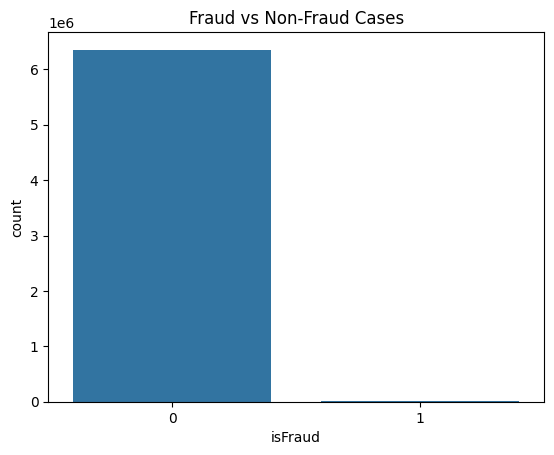

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution
sns.countplot(x='isFraud', data=df)  # Replace 'fraudulent' with actual column name
plt.title("Fraud vs Non-Fraud Cases")
plt.show()


In [6]:
import numpy as np

# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = numeric_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))



In [7]:
from sklearn.model_selection import train_test_split

# Define independent variables (X) and dependent variable (y)
X = df.drop(columns=['isFraud'])  # Replace 'fraudulent' with actual fraud label column
y = df['isFraud']

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [12]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Dictionary to store label encoders
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    
    # Fit only on training data
    X_train[col] = le.fit_transform(X_train[col])
    
    # Store label encoder for later use
    label_encoders[col] = le
    
    # Transform test data safely by handling unseen labels
    X_test[col] = X_test[col].map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)


In [14]:
X_train_sample = X_train.sample(frac=0.01, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

model = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train_sample, y_train_sample)


RandomForestClassifier(max_depth=10, n_estimators=20, n_jobs=-1,
                       random_state=42)

In [15]:
model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [18]:
# Identify columns with non-numeric data in X_test
non_numeric_cols = X_test.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['nameOrig', 'nameDest'], dtype='object')


In [19]:
from sklearn.preprocessing import LabelEncoder

# Apply Label Encoding (Ensure the same encoder is used)
for col in non_numeric_cols:
    if col in label_encoders:  # Use the same encoder from training
        X_test[col] = X_test[col].map(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)
    else:
        print(f"Warning: Encoder for {col} not found!")

# Convert to numeric type
X_test = X_test.apply(pd.to_numeric, errors='coerce')

# Take a sample of the test set
sample_fraction = 0.01  # Use 1% of the test set to speed up
X_test_sample = X_test.sample(frac=sample_fraction, random_state=42)
y_test_sample = y_test.loc[X_test_sample.index]

# Make predictions
y_pred_sample = model.predict(X_test_sample)

# Compute evaluation metrics
accuracy = accuracy_score(y_test_sample, y_pred_sample)
print("Accuracy on test sample:", accuracy)

report = classification_report(y_test_sample, y_pred_sample)
print("Classification Report on test sample:\n", report)

conf_matrix = confusion_matrix(y_test_sample, y_pred_sample)
print("Confusion Matrix on test sample:\n", conf_matrix)


Accuracy on test sample: 0.9997642436149312
Classification Report on test sample:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12712
           1       1.00      0.77      0.87        13

    accuracy                           1.00     12725
   macro avg       1.00      0.88      0.93     12725
weighted avg       1.00      1.00      1.00     12725

Confusion Matrix on test sample:
 [[12712     0]
 [    3    10]]


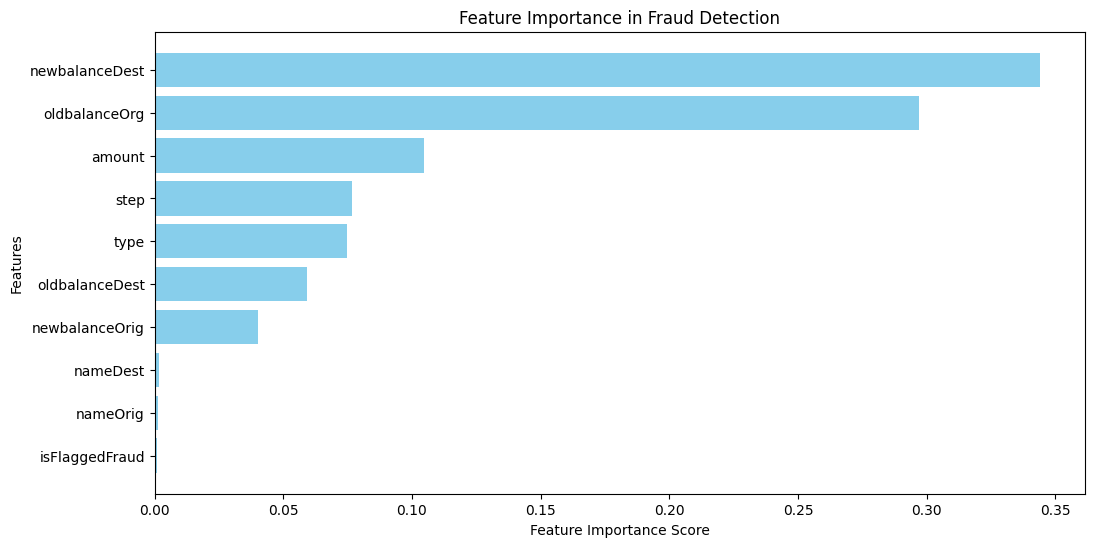

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importance = model.feature_importances_

# Create a DataFrame to display feature names with their importance scores
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Fraud Detection")
plt.gca().invert_yaxis()  # Reverse order for better visualization
plt.show()


In [21]:
# Find misclassified cases
misclassified = X_test_sample.copy()
misclassified['Actual'] = y_test_sample
misclassified['Predicted'] = y_pred_sample

# Show false positives (Non-Fraud classified as Fraud)
false_positives = misclassified[(misclassified['Actual'] == 0) & (misclassified['Predicted'] == 1)]
print("False Positives (Genuine transactions flagged as Fraud):\n", false_positives.head())

# Show false negatives (Fraud classified as Non-Fraud)
false_negatives = misclassified[(misclassified['Actual'] == 1) & (misclassified['Predicted'] == 0)]
print("False Negatives (Fraud transactions missed):\n", false_negatives.head())


False Positives (Genuine transactions flagged as Fraud):
 Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFlaggedFraud, Actual, Predicted]
Index: []
False Negatives (Fraud transactions missed):
          step  type     amount  nameOrig  oldbalanceOrg  newbalanceOrig  \
5662480   396     1  233699.25       NaN      233699.25             0.0   
2714605   211     1   73599.57       NaN       73599.57             0.0   
6334492   691     1  473086.28       NaN      473086.28             0.0   

         nameDest  oldbalanceDest  newbalanceDest  isFlaggedFraud  Actual  \
5662480       NaN            0.00       233699.25               0       1   
2714605       NaN            0.00        73599.57               0       1   
6334492       NaN     22270848.04     22743934.32               0       1   

         Predicted  
5662480          0  
2714605          0  
6334492          0  


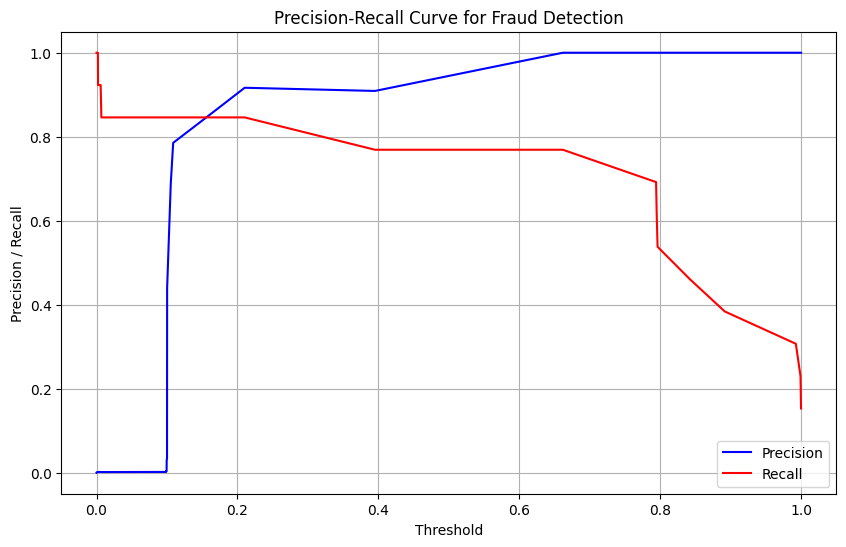

In [22]:
from sklearn.metrics import precision_recall_curve

# Get prediction probabilities
y_scores = model.predict_proba(X_test_sample)[:, 1]  # Probabilities for class "1" (Fraud)

# Compute precision-recall tradeoff
precision, recall, thresholds = precision_recall_curve(y_test_sample, y_scores)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color='blue')
plt.plot(thresholds, recall[:-1], label="Recall", color='red')
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall Curve for Fraud Detection")
plt.legend()
plt.grid()
plt.show()


In [23]:
optimal_threshold = 0.4  # Adjust based on precision-recall curve

# New predictions based on adjusted threshold
y_pred_adjusted = (y_scores >= optimal_threshold).astype(int)

# Compute new metrics
accuracy = accuracy_score(y_test_sample, y_pred_adjusted)
print(f"New Accuracy with threshold {optimal_threshold}: {accuracy}")


New Accuracy with threshold 0.4: 0.9997642436149312
